In [26]:
import pandas as pd
import os
import glob
import matplotlib.pylab as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.markersize'] = 1.0


In [4]:
data_front = "../FE_block1_autotracks_front/23442333"
data_back = "../FE_block1_autotracks_back/23442333"
test_b = data_back+"/20210911_060000.23442333/23442333_20210911_060000.23442333_000004_2021-11-13T13_15_22_13428.csv"

filenames_f = glob.glob("{}/**/*.csv".format(data_front), recursive=True)
filenames_b = glob.glob("{}/**/*.csv".format(data_back), recursive=True)

In [7]:
num = 99
df = pd.read_csv(filenames_f[num],skiprows=3, delimiter=';', error_bad_lines=False)
db = pd.read_csv(filenames_b[num],skiprows=3, delimiter=';', error_bad_lines=False)


In [31]:
db.y[:9]

0   -0.222222
1   -0.222222
2         NaN
3    2.533717
4    2.545421
5    2.463098
6    2.474699
7    2.521694
8    2.545205
Name: y, dtype: float64

[Text(0.5, 0, 'x coordinate'),
 Text(0, 0.5, 'y coordinate'),
 Text(0.5, 1.0, 'Fish trajectory over time')]

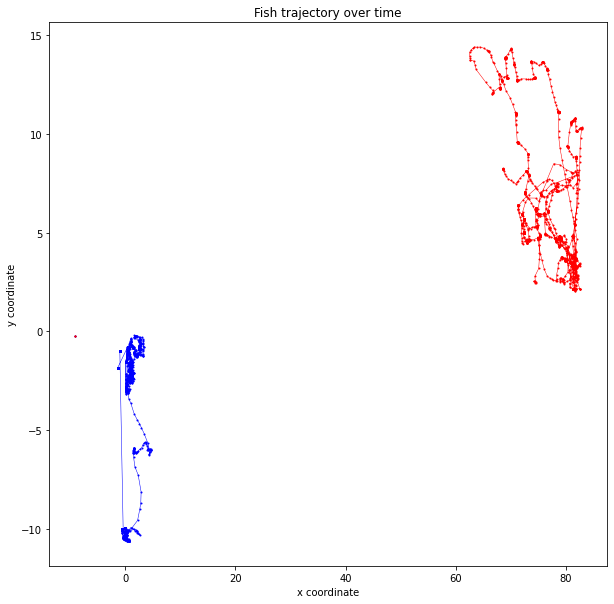

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

limit = int(len(df.x)/4)
ax.plot(df.x[:limit], df.y[:limit],'b-o', label='All trajectory points front ')
ax.plot(db.x[:limit], db.y[:limit], 'r-o', label='All trajectory points back ')

ax.set(
    xlabel='x coordinate', 
    ylabel='y coordinate', 
    title='Fish trajectory over time'
)

In [136]:
h1[["x","y"]]["x"]

0       -9.222222
1       -9.222222
2             NaN
3       -1.000000
4       -1.000000
          ...    
9995    13.252353
9996    13.238704
9997    13.305059
9998    13.305059
9999    13.305059
Name: x, Length: 10000, dtype: float64